### Task 1.1


In [5]:
def extract_words_tokens(any_string: str):
    without_space_string = any_string.strip().split()
    num_words = len(without_space_string)
    num_tokens = len(any_string)
    return(print(any_string, ":", "num_words:", num_words, "and", "num_tokens:", num_tokens, "respectively"))

### Task 1.2

In [6]:
def lemmatize(any_string, file_name):
    lemma_dict = {}
    with open(file_name, 'r', encoding="utf-8-sig") as file:
        for line in file:
            lemma, word_form = line.strip().split("\t")
            lemma_dict[word_form] = lemma
    
    input_words = any_string.split()
    
    dictionary_of_lemmatized_words = {}
    for word in input_words:
        word_without_special_characters = ''.join(e for e in word if e.isalnum())
        lower_word_without_special_characters = word_without_special_characters.lower()

        dictionary_of_lemmatized_words[word_without_special_characters] = lemma_dict.get(lower_word_without_special_characters, lower_word_without_special_characters)
    
    return dictionary_of_lemmatized_words

### Task 2

In [7]:
import pandas as pd


column_names = ["Text", "Label"]
polarity_df = pd.read_csv("./polarity.txt", delimiter="\t", header=None, names=column_names)
polarity_df.head()

,Text,Label
0,every now and then a movie comes along from a ...,pos
1,"mtv films' _election , a high school comedy st...",pos
2,did anybody know this film existed a week befo...,pos
3,the plot is deceptively simple .,pos
4,george washington carver high school is having...,pos


### Task 2.1

In [8]:
mapping = {
    "pos": 1,
    "neg": 0
}

polarity_df["Label"] = polarity_df["Label"].apply(lambda r: mapping[r])
polarity_df.head()

,Text,Label
0,every now and then a movie comes along from a ...,1
1,"mtv films' _election , a high school comedy st...",1
2,did anybody know this film existed a week befo...,1
3,the plot is deceptively simple .,1
4,george washington carver high school is having...,1


### Task 3

In [9]:
import csv
from collections import Counter

def create_count_and_probability(file_name):
    with open(file_name, 'r') as file:
        lines = file.readlines()
    
    vocabulary = set()
    for line in lines:
        lemmatized_words = lemmatize(line, "lemmatization-en.txt").values()
        vocabulary.update(lemmatized_words)

    vocabulary = sorted(vocabulary)
    
    with open('output.csv', 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['Text', 'Count_Vector', 'Probability']) 
        
        for line in lines:
            lemmatized_words_dict = lemmatize(line, "lemmatization-en.txt")

            lemmatized_words = []
            for word in line.split():
                word_without_special_characters = ''.join(e for e in word if e.isalnum()).lower()
                lemmatized_word = lemmatized_words_dict.get(word_without_special_characters, word_without_special_characters)
                lemmatized_words.append(lemmatized_word)
            
            word_count = Counter(lemmatized_words)
            
            count_vector = [word_count[word] for word in vocabulary]

            total_words = sum(count_vector)
            probability_vector = [word_count[word] / total_words if total_words > 0 else 0 for word in lemmatized_words]
            writer.writerow([line.strip(), count_vector, probability_vector])

    return ('output.csv')

create_count_and_probability("corpus.txt")


'output.csv'

# Task 4

In [11]:
import pandas as pd

# Load and label data
def load_data(file_path, label):
    with open(file_path, 'r') as file:
        documents = file.readlines()
    return pd.DataFrame({'Document': [doc.strip() for doc in documents], 'Class': label})

# Load rural and science datasets
rural_df = load_data('rural.txt', 'rural')
science_df = load_data('science.txt', 'science')

# Combine into a single DataFrame
data_df = pd.concat([rural_df, science_df], ignore_index=True)
data_df.head()

,Document,Class
0,PM denies knowledge of AWB kickbacks,rural
1,The Prime Minister has denied he knew AWB was ...,rural
2,Letters from John Howard and Deputy Prime Mini...,rural
3,In one of the letters Mr Howard asks AWB manag...,rural
4,The Opposition's Gavan O'Connor says the lette...,rural


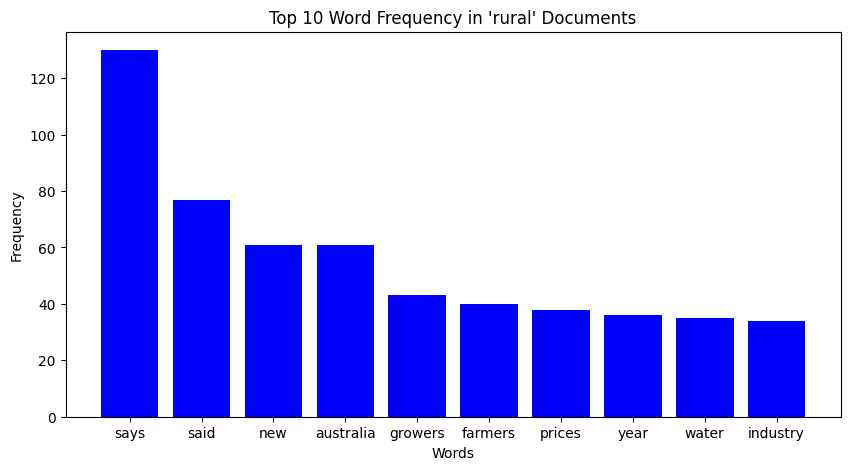

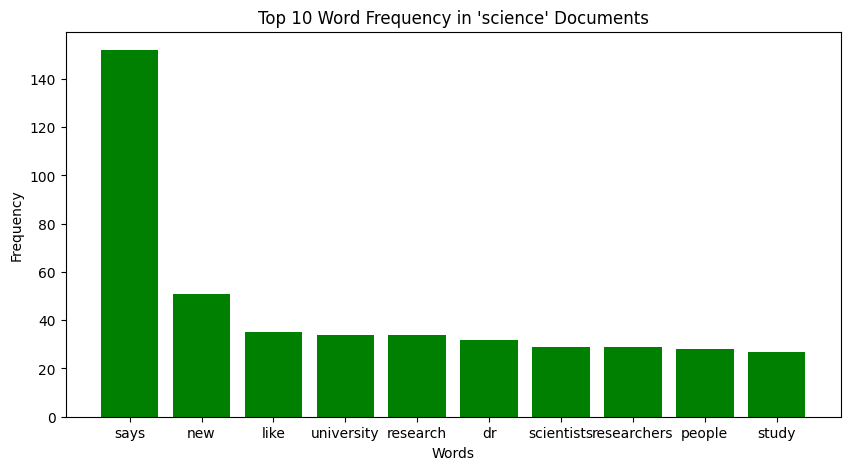

In [14]:
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt

# Remove stop words and calculate word frequency
def plot_word_frequency(df, label):
    # Filter data by class label
    texts = df[df['Class'] == label]['Document']
    # Vectorize without stop words
    vectorizer = CountVectorizer(stop_words='english')
    word_counts = vectorizer.fit_transform(texts)
    word_freq = word_counts.sum(axis=0).A1  # Get total frequency for each word
    
    # Convert to DataFrame for plotting
    freq_df = pd.DataFrame({'word': vectorizer.get_feature_names_out(), 'count': word_freq})
    freq_df = freq_df.sort_values(by='count', ascending=False).head(10) # Top 10 words
    
    # Plot
    plt.figure(figsize=(10, 5))
    plt.bar(freq_df['word'], freq_df['count'], color='blue' if label == 'rural' else 'green')
    plt.title(f"Top 10 Word Frequency in '{label}' Documents")
    plt.xlabel("Words")
    plt.ylabel("Frequency")
    plt.show()

# Plot for both classes
plot_word_frequency(data_df, 'rural')
plot_word_frequency(data_df, 'science')


In [16]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import CountVectorizer

# Split the data
X_train, X_test, y_train, y_test = train_test_split(data_df['Document'], data_df['Class'], test_size=0.3, random_state=42)

# Helper function to train and test classifiers
def train_and_test(vectorizer, classifier_name):
    # Fit and transform training data, transform test data
    X_train_vect = vectorizer.fit_transform(X_train)
    X_test_vect = vectorizer.transform(X_test)
    
    if classifier_name == 'GaussianNB':
        model = GaussianNB()
        X_train_vect = X_train_vect.toarray()  # Convert to dense matrix for GaussianNB
        X_test_vect = X_test_vect.toarray()
    else:
        model = LogisticRegression(max_iter=1000)
    
    # Train and predict
    model.fit(X_train_vect, y_train)
    y_pred = model.predict(X_test_vect)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{classifier_name} with {'One-Hot' if vectorizer.binary else 'Count'} Vectorization Accuracy: {accuracy:.3f}")

# One-Hot Encoding and Count Vectorization with both classifiers
one_hot_vectorizer = CountVectorizer(binary=True, stop_words='english')
count_vectorizer = CountVectorizer(binary=False, stop_words='english')

train_and_test(one_hot_vectorizer, 'GaussianNB')
train_and_test(one_hot_vectorizer, 'LogisticRegression')
train_and_test(count_vectorizer, 'GaussianNB')
train_and_test(count_vectorizer, 'LogisticRegression')


GaussianNB with One-Hot Vectorization Accuracy: 0.917
LogisticRegression with One-Hot Vectorization Accuracy: 0.893
GaussianNB with Count Vectorization Accuracy: 0.911
LogisticRegression with Count Vectorization Accuracy: 0.890
